# Integrating Orbits about an orbiting satellite

This recipe is a minimum working example for integrating orbits in a circularly orbiting but fixed potential.  We compute and compare both the inertial and non-inertial frames.

As in the linear motion case, we:
1. Build the basis and coefficients from scratch
2. Implement a orbiting basis
3. Integrate orbits in the inertial frame

In [1]:
# some preliminaries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import pyEXP
import pyEXP

# check the version
pyEXP.util.getVersionInfo()


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% This is EXP 7.8.2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Repository URL | https://github.com/EXP-code/EXP                         %
%%%%% Current branch | pseudoAccel                                             %
%%%%% Current commit | 186ceffc9434dd7d1424e17e7ff16a5f180a25e2                %
%%%%% Compile time   | 2025-04-22 13:34:01 EDT                                 %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



In [3]:
lmax,nmax = 4,10

bconfig = """
---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: {}
  nmax: {}
  rmapping: 0.0667
  modelname: SLGridSph.model
  cachename: sphereSL.cache
...
""".format(lmax,nmax)

# Construct the basis instance
#
halo_basis   = pyEXP.basis.Basis.factory(bconfig)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.cache>
---- Spherical::orthoTest: worst=0.00016446


In [4]:
# now make a custom array of complex coefficients to install
lnumber = int((lmax+1)*(lmax+2)/2)
halo_coef_matrix = np.zeros([lnumber,nmax], dtype=np.complex128)

# set just the lowest-order term
halo_coef_matrix[0,0]=1.0

## Try an orbiting field

In [5]:
# make dummy coefficients for this basis to test orbits
halo_coef  = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(halo_coef, 'halo')

# Orbit at R=3
Ro     = 3.0
Period = 100
Freq   = 2.0*np.pi/Period
Time   = 0.0
dT     = 0.1

# Build a time series for testing the non-inertial logic
ctimes = []
center = []

while Time < Period+dT/2:
    # Define the center position
    Phi = Freq*Time
    x = Ro*np.cos(Phi)
    y = Ro*np.sin(Phi)
    # Make new coef structure
    coef = halo_coef.deepcopy()
    coef.setCoefTime(Time)
    coef.setCoefCenter([x, y, 0.])
    # Use the previously defined constant coefficients
    coef.assign(halo_coef_matrix, lmax, nmax)
    # Add to the coefficient database
    halo_coefs.add(coef)
    # Center times and positions
    ctimes.append(Time)
    center.append([x, y, 0.])
    # Next time
    Time += dT

###  Now that we have a coefficients that cover [0, 300], we can integrate an orbit

In [6]:
Ri = 0.25
Vi = 0.5
h  = 0.01

# pick a phase space for some orbit:
ps = [[Ro+Ri, 0.0, 0.0, 0.0, Vi, 0.0]]

# set up the model with the basis and coefficients
model = [[halo_basis, halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

# explicitly set inertial coordinates
# inertial is the default but will be needed if you rerun all cells
halo_basis.setInertial()

start_time,end_time,dt = 0.0,Period,h
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, func)

### Plot the orbit

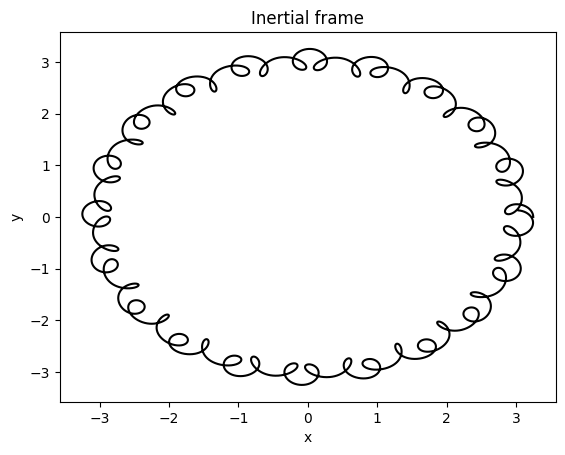

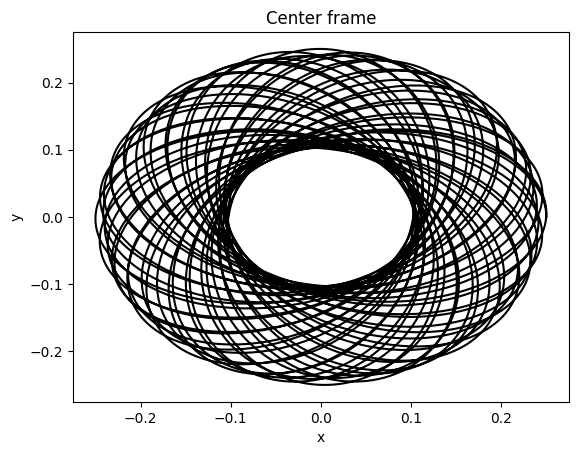

In [7]:
plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Inertial frame')
plt.show()

plt.plot(orbits[0][0,:]-Ro*np.cos(Freq*times), orbits[0][1,:]-Ro*np.sin(Freq*times),color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Center frame')
plt.show()

## We can now use the same coefficient set to test the orbits in the non-inertial frame

In [8]:
# pick a phase space for some orbit:
ps2 = [[Ri, 0.0, 0.0, 0.0, Vi-Freq*Ro, 0.0]]

# set up the non-internal frame
halo_basis.setNonInertial(40, ctimes, center)

# set up the model with the basis and coefficients
model = [[halo_basis, halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,Period,h
# integrate the orbit
times2, orbits2 = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps2, model, func)

### Plot the orbit in the moving frame

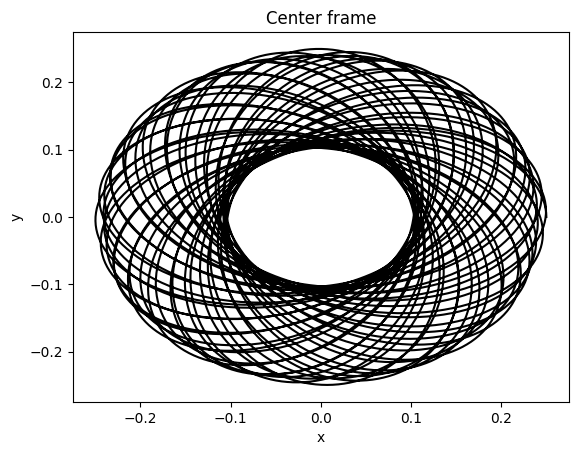

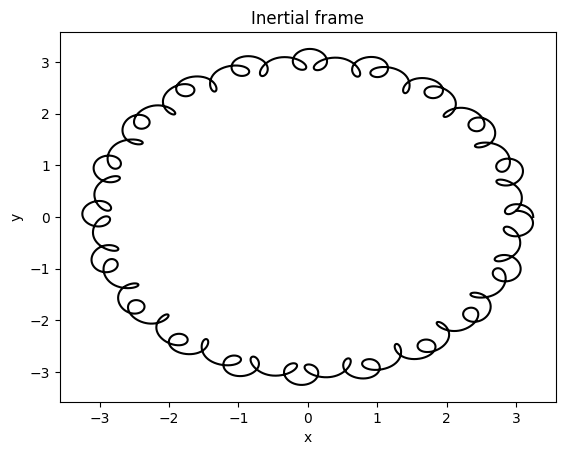

In [9]:
plt.plot(orbits2[0][0,:],orbits2[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Center frame')
plt.show()

plt.plot(orbits2[0][0,:]+Ro*np.cos(Freq*times2), orbits2[0][1,:]+Ro*np.sin(Freq*times2),color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Inertial frame')
plt.show()

## Compare with first set of orbits

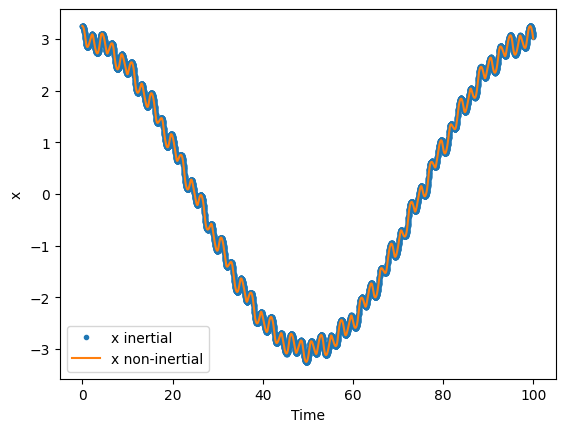

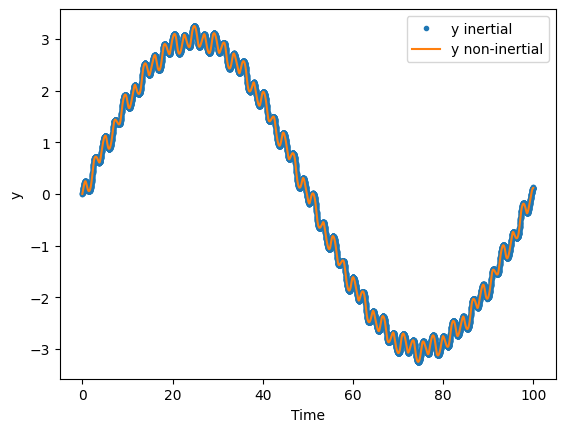

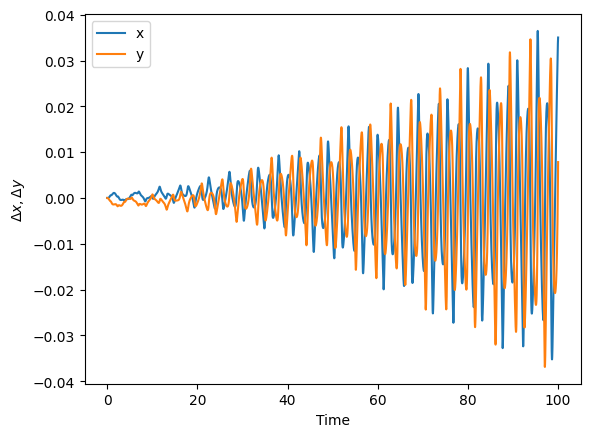

In [10]:
# x coordinate values for inertial frame
x = orbits[0][0, :]
plt.plot(times, x, '.', label='x inertial')

# x coordinate values for non-inertial frame in inertial system
x = orbits2[0][0, :] + Ro*np.cos(Freq*times2)
plt.plot(times2, x, label='x non-inertial')

plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.show()

# y coordinate values for inertial frame
y = orbits[0][1, :]
plt.plot(times, y, '.', label='y inertial')

# y coordiante values for non-inertial frame in inertial system
y = orbits2[0][1, :]+Ro*np.sin(Freq*times2)
plt.plot(times2, y, label='y non-inertial')

plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

# differences
plt.plot(times, orbits[0][0, :]-orbits2[0][0, :]-Ro*np.cos(Freq*times2), label='x')
plt.plot(times, orbits[0][1, :]-orbits2[0][1, :]-Ro*np.sin(Freq*times2), label='y')
plt.xlabel('Time')
plt.ylabel(r'$\Delta x, \Delta y$')
plt.legend()
plt.show()

Decreasing the step size decreases the differences in the final plot suggesting that we are seeing some accumulating truncation effects.